In [4]:
# Parameters
initial_num_points = 800
final_points = 500
alpha = 1.0
max_time = 30.0
min_time = 5.0
num_iterations = 20
boundary = 30
c_drag = 1.0
image_size = 100
num_cores = 1
dataset = 'u2'

In [5]:
import numpy as np
import matplotlib.pyplot as plt

import tifffile as tf
import os
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import cm
import cv2
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.integrate import odeint
import time
from numpy import linalg as LA
import random
from itertools import cycle
from scipy import interpolate
import cv2
import multiprocessing as mp
from skimage.transform import rescale

%matplotlib inline

def nanRobustBlur(I, dim):
    V=I.copy()
    V[I!=I]=0
    VV=cv2.blur(V,dim)   
    W=0*I.copy()+1
    W[I!=I]=0
    WW=cv2.blur(W,dim)    
    Z=VV/WW
    return Z

anisotropy = cv2.imread('2d_data/' + dataset + '/retardance.tif', -1).astype('float32')
orientation = cv2.imread('2d_data/' + dataset + '/azimuth.tif', -1).astype('float32')
anisotropy = rescale(anisotropy, 0.5, anti_aliasing=True)
orientation = rescale(orientation, 0.5, anti_aliasing=True)
anisotropy = anisotropy / 65535*10
orientation = orientation / 18000*np.pi

def return_smooth(orientation, anisotropy):
    U, V =  anisotropy*np.cos(2 * orientation), anisotropy*np.sin(2 * orientation)
    USmooth = nanRobustBlur(U, (5, 5)) # plot smoothed vector field
    VSmooth = nanRobustBlur(V, (5, 5)) # plot smoothed vector field
    azimuthSmooth = (0.5*np.arctan2(VSmooth,USmooth)) % np.pi
    RSmooth = np.sqrt(USmooth**2+VSmooth**2)
    
    return RSmooth, azimuthSmooth

anisotropy, orientation = return_smooth(orientation, anisotropy)

def return_D(position):
    scale_value = anisotropy[position[0]][position[1]]
    theta = orientation[position[0]][position[1]]
    
    if abs(scale_value) > 1:
        scale_matrix = np.matrix([[scale_value, 0], [0, 1]])
    else:
        scale_matrix = np.matrix([[1, 0], [0, scale_value]])
    
    angle_matrix = np.matrix([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    angle_matrix_2 = np.matrix([[np.cos(theta), np.sin(theta)], [-np.sin(theta), np.cos(theta)]])
    
    D_matrix = np.matmul(np.matmul(angle_matrix, scale_matrix), angle_matrix_2)
    
    return D_matrix

memory_inverse = {}

D1 = np.zeros_like(anisotropy, dtype=np.float32)
D2 = np.zeros_like(anisotropy, dtype=np.float32)
D3 = np.zeros_like(anisotropy, dtype=np.float32)
D4 = np.zeros_like(anisotropy, dtype=np.float32)

x = np.arange(0, anisotropy.shape[0], 1)
y = np.arange(0, anisotropy.shape[1], 1)

for i in x:
    for j in y:
        scale_matrix = return_D([i, j])
        memory_inverse[(i, j)] = np.linalg.inv(scale_matrix)

        D1[i, j] = scale_matrix[0, 0]
        D2[i, j] = scale_matrix[0, 1]
        D3[i, j] = scale_matrix[1, 0]
        D4[i, j] = scale_matrix[1, 1]

D1_interp = interpolate.interp2d(x, y, D1.T, kind='cubic')
D2_interp = interpolate.interp2d(x, y, D2.T, kind='cubic')
D3_interp = interpolate.interp2d(x, y, D3.T, kind='cubic')
D4_interp = interpolate.interp2d(x, y, D4.T, kind='cubic')

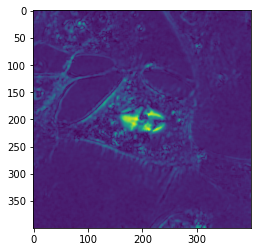

In [6]:
plt.imshow(anisotropy)

In [42]:
anisotropy.shape

(800, 800)

In [22]:
# plt.imshow(edges_y)

In [23]:
def return_D_interp(position):
    D1_value = D1_interp(position[0], position[1])[0]
    D2_value = D2_interp(position[0], position[1])[0]
    D3_value = D3_interp(position[0], position[1])[0]
    D4_value = D4_interp(position[0], position[1])[0]
    
    return np.matrix([[D1_value, D2_value], [D3_value, D4_value]])

In [24]:
def return_D_inverse(pos_a, pos_b):
    pos_a = ([int(x) for x in pos_a])
    pos_b = ([int(x) for x in pos_b])
    pos_a = (pos_a[0], pos_a[1])
    pos_b = (pos_b[0], pos_b[1])

    if pos_a not in memory_inverse.keys() and pos_b not in memory_inverse.keys():
        D_inverse_ab = np.identity(2)
    elif pos_a not in memory_inverse.keys():
        D_inverse_ab = memory_inverse[pos_b]
    elif pos_b not in memory_inverse.keys():
        D_inverse_ab = memory_inverse[pos_a]
    else:
        D_inverse_ab = (memory_inverse[pos_a] + memory_inverse[pos_b])/2.0

    return D_inverse_ab

In [25]:
gamma = 0.5
def force_function_list(r):
    
    mask_1 = np.logical_and(r < 1, r > 0)
    mask_2 = np.logical_and(r >= 1, r <= 1 + gamma)
    mask_3 = r > 1+gamma
    
    return mask_1*(r-1) + mask_2*(((r-1)*(1+gamma-r)**2)/gamma**2) + mask_3*(0)

In [26]:
from numba import jit, prange

@jit(nopython=True)
def invert_matrix(matrices):
    inverted_list = np.empty_like(matrices)
    
    for i in prange(matrices.shape[0]):
        inverted_list[i] = np.linalg.inv(matrices[i])

    return inverted_list

In [27]:
def return_matrix(position):
    D1_value = D1_interp(position[0], position[1])[0]
    D2_value = D2_interp(position[0], position[1])[0]
    D3_value = D3_interp(position[0], position[1])[0]
    D4_value = D4_interp(position[0], position[1])[0]

    matrix = np.array([[D1_value, D2_value], [D3_value, D4_value]])
    
    return matrix

In [28]:
def return_total_force(pos_a, pos_b_positions, approx=True):
    total_force = np.zeros((2, 1))
    matrices = np.zeros((len(pos_b_positions), 2, 2))
    identity = np.identity(2, dtype=float)
    
    if approx:
        D_inverse_list = []
        for pos_b in pos_b_positions:
                D_inverse_list.append(return_D_inverse(pos_a, pos_b))

        D_inverse_list = np.array(D_inverse_list)
    else:            
        positions = np.add(pos_a, pos_b_positions)/2.0
        
        for k in range(len(positions)):
            matrices[k] = return_matrix(positions[k])
        
        D_inverse_list = invert_matrix(matrices)

    pos_a_np = np.asarray(pos_a, dtype='float32')

    y_ab_stack = pos_a_np - pos_b_positions
    y_ab_stack = y_ab_stack.reshape(len(pos_b_positions), 2, 1)

    x_ab_list = np.transpose(np.einsum('ijk,ikl->ijl', D_inverse_list, y_ab_stack)[:,:,0])/(2*alpha)
    x_ab_dist_list = LA.norm(x_ab_list, axis=0) + 1e-5

    mult = np.transpose(x_ab_list).reshape(x_ab_list.shape[1], x_ab_list.shape[0], 1)
    force_list = -force_function_list(x_ab_dist_list)*np.transpose(np.einsum('ijk,ikl->ijl', D_inverse_list, mult)[:,:,0])/(2*alpha*x_ab_dist_list)
    total_force += np.sum(force_list, axis = 1).reshape((2, 1))   
            
    return total_force

In [29]:
random_rows = np.random.choice(anisotropy.shape[0], initial_num_points)
random_columns = np.random.choice(anisotropy.shape[1], initial_num_points)
random_points = list(zip(random_rows, random_columns))

In [30]:
det_D_list = [np.linalg.det(return_D_interp(pos)) for pos in random_points]
max_det = max(det_D_list)
det_D_list = [x/max_det for x in det_D_list]
points_rejected = np.random.choice(len(random_points), initial_num_points - final_points, det_D_list)
final_points = [random_points[i] for i in range(len(random_points)) if i not in points_rejected]

In [31]:
eig_D = [max(np.linalg.eig(return_D_interp(pos))[0]) for pos in random_points]
max_eig = max(eig_D)

In [32]:
edge_length = 2*alpha*max_eig*(1+gamma)

def bin_coords(pos):
    x_coord = np.floor(pos[0]/edge_length)
    y_coord = np.floor(pos[1]/edge_length)
    
    return (x_coord, y_coord)

In [33]:
curr_points = final_points

def form_dict(points):
    dict_points = {}

    for point in points:
        bin_coord = bin_coords(point)

        if bin_coord in dict_points.keys():
            dict_points[bin_coord].append(point)
        else:
            dict_points[bin_coord] = [point]
    
    return dict_points

In [34]:
def total_force_on_point(index, list_points, map_points, approx=True):
    p_a = list_points[index]
    bin_coord = bin_coords(p_a)
    bin_x = bin_coord[0]
    bin_y = bin_coord[1]

    points_cons = []

    points_cons += map_points[bin_coord]

    if bin_x - 1 >= 0:
        if (bin_x - 1, bin_y) in map_points.keys():
            points_cons += map_points[(bin_x - 1, bin_y)]

    if bin_y - 1 >= 0:
        if (bin_x, bin_y - 1) in map_points.keys():
            points_cons += map_points[(bin_x, bin_y - 1)]

    if bin_x + 1 < anisotropy.shape[0]:
        if (bin_x + 1, bin_y) in map_points.keys():
            points_cons += map_points[(bin_x + 1, bin_y)]

    if bin_y + 1 < anisotropy.shape[1]:
        if (bin_x, bin_y + 1) in map_points.keys():
            points_cons += map_points[(bin_x, bin_y + 1)]
    
    total_force = return_total_force(p_a, points_cons, approx)

    return total_force, len(points_cons)

In [35]:
def diff_equation(y, t, c_drag, total_force):
    p0, p1, r0, r1 = y
    dydt = [r0, r1, total_force[0] - c_drag*r0, total_force[1] - c_drag*r1]
    return dydt

def solve_particle_path(index, initial_pos, map_points, time_integrate, approx=True):
    y0 = [initial_pos[index][0], initial_pos[index][1], 0.0, 0.0]  
    t = np.linspace(0, time_integrate, 10) 
    tf, tot_points = total_force_on_point(index, initial_pos, map_points, approx)
    sol = odeint(diff_equation, y0, t, args=(c_drag, tf))
    
    return sol, tot_points

def solve_particle_path_multiple(index_start, initial_pos, map_points, time_integrate, num_points_per_core, approx=True):
    sol_list = []
    tot_points_list = []
    
    if index_start + num_points_per_core < len(initial_pos):
        limit = index_start + num_points_per_core
    else:
        limit = len(initial_pos)

    for index in range(index_start, limit):
        y0 = [initial_pos[index][0], initial_pos[index][1], 0.0, 0.0]  
        t = np.linspace(0, time_integrate, 10) 
        tf, tot_points = total_force_on_point(index, initial_pos, map_points, approx)
        sol = odeint(diff_equation, y0, t, args=(c_drag, tf))
        sol_list.append(sol)
        tot_points_list.append(tot_points)
        
    return sol_list, tot_points_list

In [36]:
map_points = form_dict(curr_points)

slope = (max_time - min_time)/(1 - num_iterations)
constant = (num_iterations*max_time - min_time)/(num_iterations - 1)      
pool = mp.Pool(num_cores)

start_algo = time.time()
for k in range(num_iterations):
    start_iteration = time.clock()
    final_positions = []
    num_particles = 0
    total_dist = 0
    new_map_points = {}
    avg_total_points = 0
    time_integrate = slope*(k+1) + constant
    
    total_points = len(curr_points)
    num_points_per_core = int(total_points/num_cores)
    
    if k < 8:
        processes = [pool.apply_async(solve_particle_path_multiple, args=(i, curr_points, map_points, time_integrate, num_points_per_core, True)) for i in range(0, total_points, num_points_per_core)]
    else:
        processes = [pool.apply_async(solve_particle_path_multiple, args=(i, curr_points, map_points, time_integrate, num_points_per_core, False)) for i in range(0, total_points, num_points_per_core)]
        
    results = [process.get() for process in processes]

    for i in range(len(results)):
        sol_list = results[i][0]
        tot_points_list = results[i][1]
        
        for j in range(len(sol_list)):
            sol = sol_list[j]
            tot_points = tot_points_list[j]

            if sol[-1, 0] >= -boundary and sol[-1, 0] <= anisotropy.shape[0] + boundary and \
               sol[-1, 1] >= -boundary and sol[-1, 1] <= anisotropy.shape[1] + boundary:
                final_positions.append((sol[-1, 0], sol[-1, 1]))
                num_particles += 1
                avg_total_points += tot_points
                total_dist += LA.norm(np.array([sol[-1, 0], sol[-1, 1]]) - np.array([sol[0, 0], sol[0, 1]]))     

                new_bin_coord = bin_coords((sol[-1, 0], sol[-1, 1]))

                if new_bin_coord in new_map_points.keys():
                    new_map_points[new_bin_coord].append((sol[-1, 0], sol[-1, 1]))
                else:
                    new_map_points[new_bin_coord] = [(sol[-1, 0], sol[-1, 1])]
    
    if k%4 == 0: 
        print("Distances moved by particle:", total_dist/num_particles)
        print("Number of particles:", num_particles)
        print("Number of particles for force:", avg_total_points/num_particles)
        end_iteration = time.clock()
        print("Time taken for iteration: ", end_iteration - start_iteration)
        print("")
    
    curr_points = final_positions
    map_points = new_map_points
    
    if total_dist/num_particles < 0.3:
        break
        
end_algo = time.time()

print("Total time taken: ", end_algo - start_algo)

Distances moved by particle: 0.1474576785499397
Number of particles: 2537
Number of particles for force: 17.410721324398896
Time taken for iteration:  0.06505800000000761

Total time taken:  1.4051682949066162


In [37]:
final_positions = np.array(final_positions)
final_positions = np.around(final_positions, decimals=0)

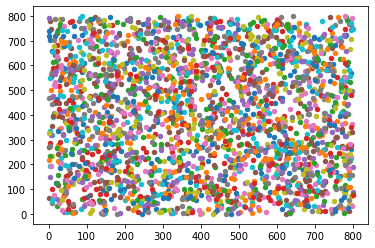

In [38]:
for i in range(len(final_positions)):
    if final_positions[i][0] >= 0 and final_positions[i][0] <= anisotropy.shape[0] and final_positions[i][1] >= 0 and final_positions[i][1] <= anisotropy.shape[1]:
        plt.scatter(final_positions[i][0], final_positions[i][1], s=20)

In [39]:
USmooth, VSmooth = anisotropy*np.cos(orientation), anisotropy*np.sin(orientation)
final_positions = final_positions.astype(int)

In [40]:
Plotting_X = []
Plotting_Y = []
Plotting_U = []
Plotting_V = []
Plotting_orient = []

USmooth = USmooth*0.5
VSmooth = VSmooth*0.5

for i in range(len(final_positions)):
    if final_positions[i][0] >= 0 and final_positions[i][0] < anisotropy.shape[0] and final_positions[i][1] >= 0 and final_positions[i][1] < anisotropy.shape[1]:
        Plotting_X.append(final_positions[i][0])
        Plotting_Y.append(final_positions[i][1])
        Plotting_U.append(USmooth[final_positions[i][0], final_positions[i][1]])
        Plotting_V.append(VSmooth[final_positions[i][0], final_positions[i][1]])
        Plotting_orient.append(orientation[final_positions[i][0], final_positions[i][1]])     

Plotting_color = Plotting_orient

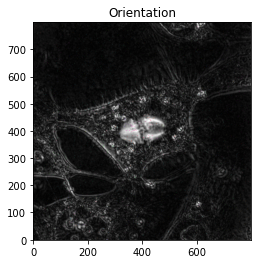

In [41]:
cmapImage = 'gray'
cmapOrient = 'hsv'
linecolor = 'g'
alpha = 0.6
linewidth = 1

im_ax = plt.imshow(anisotropy, cmap=cmapImage, origin='lower')
plt.title('Orientation')
plt.quiver(Plotting_Y, Plotting_X,
           Plotting_U, Plotting_V, Plotting_color,
           cmap=cmapOrient,
           edgecolor=linecolor, facecolor=linecolor, units='xy', alpha=alpha, width=linewidth,
           headwidth=0, headlength=0, headaxislength=0,
           scale_units = 'xy', scale = 1, angles = 'uv', pivot = 'mid')

In [ ]:
nY, nX = anisotropy.shape
Y, X = np.mgrid[0:nY,0:nX] # notice the reversed order of X and Y
spacing = 2
    
# Sample variables at the specified spacing.
Plotting_X = X[::spacing, ::spacing]
Plotting_Y = Y[::spacing, ::spacing]
Plotting_U = USmooth[::spacing, ::spacing]
Plotting_V = VSmooth[::spacing, ::spacing]

threshold = np.ones_like(X) # no threshold
Plotting_thres = threshold[::spacing, ::spacing]
Plotting_orient=orientation[::spacing, ::spacing]

thresholdIdx = Plotting_thres==1
Plotting_X=Plotting_X[thresholdIdx]
Plotting_Y=Plotting_Y[thresholdIdx]
Plotting_U=Plotting_U[thresholdIdx]
Plotting_V=Plotting_V[thresholdIdx]
Plotting_orient=Plotting_orient[thresholdIdx]
Plotting_color=Plotting_orient

In [ ]:
im_ax = plt.imshow(anisotropy, cmap=cmapImage)
plt.title('Orientation')
plt.quiver(Plotting_X, Plotting_Y,
           Plotting_U, Plotting_V, Plotting_color,
           cmap=cmapOrient,
           edgecolor=linecolor, facecolor=linecolor, units='xy', alpha=alpha, width=linewidth,
           headwidth=0, headlength=0, headaxislength=0,
           scale_units = 'xy', scale = 1, angles = 'uv', pivot = 'mid')

In [ ]:
USmooth, VSmooth = anisotropy*np.cos(orientation), anisotropy*np.sin(orientation)

Plotting_X = []
Plotting_Y = []
Plotting_U = []
Plotting_V = []
Plotting_orient = []

USmooth = USmooth*0.1
VSmooth = VSmooth*0.1

for i in range(len(final_points)):
        Plotting_X.append(final_points[i][0])
        Plotting_Y.append(final_points[i][1])
        Plotting_U.append(USmooth[final_points[i][0], final_points[i][1]])
        Plotting_V.append(VSmooth[final_points[i][0], final_points[i][1]])
        Plotting_orient.append(orientation[final_points[i][0], final_points[i][1]])     

Plotting_color = Plotting_orient

In [ ]:
cmapImage = 'gray'
cmapOrient = 'hsv'
linecolor = 'g'
alpha = 0.6
linewidth = 1

im_ax = plt.imshow(anisotropy, cmap=cmapImage, origin='lower')
plt.title('Orientation')
plt.quiver(Plotting_Y, Plotting_X,
           Plotting_U, Plotting_V, Plotting_color,
           cmap=cmapOrient,
           edgecolor=linecolor, facecolor=linecolor, units='xy', alpha=alpha, width=linewidth,
           headwidth=0, headlength=0, headaxislength=0,
           scale_units = 'xy', scale = 1, angles = 'uv', pivot = 'mid')